In [51]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [52]:
region_name = 'us-east-2'  # Remove the extra single quotes
sm_boto3 = boto3.client('sagemaker', region_name=region_name)
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'loaneligibilitybucket'

print('Bucket being used:', bucket)
print('Region:', region)

Bucket being used: loaneligibilitybucket
Region: us-east-2


# Data Ingestion into S3

## we will read the files and do all the processing and then finally load that data in the s3 using upload_data function from sagemaker

In [53]:

loan_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv",index_col=False)
loan_data = loan_data.drop(['Unnamed: 0'], axis=1)
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


-  Basically this below data is a completely unseen data , we will do the predictions on it in the final stage.

- we can also run a batch transformation job on this to get the batch prediction rather than real-time like how indeed or linkedin sends job notifications at certain times.

In [54]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')
test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001116,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban
1,LP001488,Male,Yes,3+,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban
2,LP002138,Male,Yes,0,Graduate,No,2625,6250.0,187.0,360.0,1.0,Rural
3,LP002284,Male,No,0,Not Graduate,No,3902,1666.0,109.0,360.0,1.0,Rural
4,LP002328,Male,Yes,0,Not Graduate,No,6096,0.0,218.0,360.0,0.0,Rural


In [55]:
# Data Preprocessing

def train_data_processing(loan_data):
    loan_data['Dependents'].replace('3+', 3,inplace=True)

    loan_data['Gender'].fillna(loan_data['Gender'].mode()[0], inplace=True)
    loan_data['Married'].fillna(loan_data['Married'].mode()[0], inplace=True)
    loan_data['Dependents'].fillna(loan_data['Dependents'].mode()[0], inplace=True)
    loan_data['Self_Employed'].fillna(loan_data['Self_Employed'].mode()[0], inplace=True)
    loan_data['Credit_History'].fillna(loan_data['Credit_History'].mode()[0], inplace=True)


    loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].mode()[0], inplace=True)
    loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].median(), inplace=True)

    loan_data['LoanAmount_log']= np.log(loan_data['LoanAmount'])
    loan_data=loan_data.drop('Loan_ID',axis=1)
    loan_data = pd.get_dummies(loan_data)
    return loan_data

def test_data_processing(test_data):
    test_data['Dependents'].replace('3+', 3,inplace=True)

    test_data['Gender'].fillna(test_data['Gender'].mode()[0], inplace=True)
    test_data['Married'].fillna(test_data['Married'].mode()[0], inplace=True)
    test_data['Dependents'].fillna(test_data['Dependents'].mode()[0], inplace=True)
    test_data['Self_Employed'].fillna(test_data['Self_Employed'].mode()[0], inplace=True)
    test_data['Credit_History'].fillna(test_data['Credit_History'].mode()[0], inplace=True)
    test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].mode()[0], inplace=True)
    test_data['LoanAmount'].fillna(test_data['LoanAmount'].median(), inplace=True)

    test_data['LoanAmount_log']= np.log(test_data['LoanAmount'])
    test_data=test_data.drop('Loan_ID',axis=1)
    test_data = pd.get_dummies(test_data)
    return test_data

loan_data = train_data_processing(loan_data)
test_data = test_data_processing(test_data)



In [9]:
from sklearn.model_selection import train_test_split

X = loan_data.drop('Loan_Status', axis = 1)
y = loan_data['Loan_Status']


In [10]:
X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,115.0,360.0,1.0,4.744932,1,0,1,0,...,1,0,0,1,0,1,0,0,1,0
1,5703,0.0,130.0,360.0,1.0,4.867534,0,1,0,1,...,0,0,0,0,1,0,1,1,0,0
2,4333,2451.0,110.0,360.0,1.0,4.700480,1,0,0,1,...,1,0,0,1,0,1,0,0,0,1
3,4695,0.0,96.0,360.0,1.0,4.564348,0,1,0,1,...,1,0,0,0,1,0,1,0,0,1
4,6700,1750.0,230.0,300.0,1.0,5.438079,0,1,0,1,...,0,0,1,1,0,1,0,0,1,0


In [11]:
y

0      1
1      1
2      0
3      1
4      1
      ..
486    1
487    1
488    1
489    0
490    1
Name: Loan_Status, Length: 491, dtype: int64

In [56]:
loan_data.to_csv("train_Data.csv", index = False)
test_data.to_csv('test_data.csv', index = False)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=123)

In [58]:
X_train.shape, X_val.shape, X_test.shape

((313, 21), (79, 21), (99, 21))

In [59]:
y_train.shape, y_val.shape, y_test.shape

((313,), (79,), (99,))

In [60]:
X_train.head(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
239,5468,1032.0,26.0,360.0,1.0,3.258097,0,1,0,1,...,0,1,0,1,0,1,0,0,1,0
3,4695,0.0,96.0,360.0,1.0,4.564348,0,1,0,1,...,1,0,0,0,1,0,1,0,0,1


In [16]:
# now we will combine the features and target into a file so that the aws sagemaker model automatically handles it and also it's easy for us to look the entire data aswell.

In [61]:
train = pd.concat([pd.Series(y_train,index=X_train.index,name = 'Loan_Status',dtype=int),X_train], axis = 1)
validation = pd.concat([pd.Series(y_val,index = X_val.index, name = 'Loan_Status', dtype=int),X_val], axis = 1)
test = pd.concat([pd.Series(y_test,index = X_test.index, name = 'Loan_Status', dtype=int),X_test], axis = 1)

In [62]:
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv',index=False, header=False)
test.to_csv('test.csv',index = False,header=False)

# so aws sagemnaker XGboost algorithm considers the first column as the target column and doesn't take the header values. So if we look above I have given headers as false during csv file saving.

## Upload the datasets to Amazon S3

In [63]:
# now we upload the data to s3, so that the sagemaker will take the training data from s3. similarly this is done in Azure ml as well, there we store the data in blob storage

sk_prefix = "sagemaker/loaneligibilityalgorithm/sklearncontainer"
# backup train data
trainpath = sess.upload_data(
    path = 'train_Data.csv' , bucket = bucket, key_prefix= sk_prefix
)

unseentestpath = sess.upload_data(
    path = 'test_data.csv' , bucket=bucket , key_prefix = sk_prefix
)


# datasets needed for the model
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(sk_prefix, 'data/train.csv').replace('\\','/')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(sk_prefix, 'data/validation.csv').replace('\\','/')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(sk_prefix, 'data/test.csv').replace('\\','/')).upload_file('test.csv')



#   ! aws s3 ls {bucket}/{prefix}/data --recursive
#   by running this we can check if the files are uploaded into that folder or not.


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## Model Training

### We can write our own training script or we can load a model from the sagemaker image_uris. we will see both the approaches

In [68]:
from sagemaker import image_uris

container = image_uris.retrieve('xgboost', region = region, version='latest')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [69]:
s3_output_location = 's3://{}/{}/xgboost_model'.format(bucket, sk_prefix)
xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    # role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    # volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    role = 'arn:aws:iam::280695184456:role/service-role/AmazonSageMaker-ExecutionRole-20240128T102744',
)

In [70]:
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 1000
)

In [71]:
from sagemaker.session import TrainingInput

train_input = TrainingInput("s3://{}/{}/{}".format(bucket,sk_prefix,'data/train.csv'), content_type='csv')
validation_input = TrainingInput("s3://{}/{}/{}".format(bucket,sk_prefix,'data/validation.csv'), content_type='csv')

In [72]:
train.head()

,Loan_Status,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
239,1,5468,1032.0,26.0,360.0,1.0,3.258097,0,1,0,...,0,1,0,1,0,1,0,0,1,0
3,1,4695,0.0,96.0,360.0,1.0,4.564348,0,1,0,...,1,0,0,0,1,0,1,0,0,1
467,0,3089,1280.0,121.0,360.0,0.0,4.795791,0,1,0,...,0,1,0,1,0,1,0,0,1,0
413,0,5746,0.0,255.0,360.0,1.0,5.541264,0,1,0,...,1,0,0,1,0,1,0,0,0,1
71,1,3254,0.0,50.0,360.0,1.0,3.912023,0,1,1,...,1,0,0,1,0,1,0,0,0,1


In [73]:
train.columns

Index(['Loan_Status', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'LoanAmount_log', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_3',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [74]:
# starting a training job

xgb_model.fit({'train': train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: xgboost-2024-02-04-19-33-19-856


2024-02-04 19:33:20 Starting - Starting the training job...
2024-02-04 19:33:34 Starting - Preparing the instances for training.........
2024-02-04 19:35:03 Downloading - Downloading input data...
2024-02-04 19:35:33 Downloading - Downloading the training image...
2024-02-04 19:36:23 Training - Training image download completed. Training in progress...Arguments: train
[2024-02-04:19:36:34:INFO] Running standalone xgboost training.
[2024-02-04:19:36:34:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 8542.62mb
[2024-02-04:19:36:34:INFO] Determined delimiter of CSV input is ','
[19:36:34] S3DistributionType set as FullyReplicated
[19:36:34] 313x21 matrix with 6573 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-02-04:19:36:34:INFO] Determined delimiter of CSV input is ','
[19:36:34] S3DistributionType set as FullyReplicated
[19:36:34] 79x21 matrix with 1659 entries loaded from /opt/ml/input/data/validati

# Deploying the model

In [96]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb_model.deploy(
    # endpoint_name= 'xgboost-2024-02-04-19-37-33-979',
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: xgboost-2024-02-04-20-22-31-763
INFO:sagemaker:Creating endpoint-config with name xgboost-2024-02-04-20-22-31-763
INFO:sagemaker:Creating endpoint with name xgboost-2024-02-04-20-22-31-763


-------!

In [97]:
xgb_predictor.endpoint_name

'xgboost-2024-02-04-20-22-31-763'

In [100]:
#let's get the predictions out of our data.

def predict(data, rows = 1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1)) # basically splits the entire dataset into equal splits
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep = ',')


In [81]:
test.head()

,Loan_Status,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
236,1,2366,2531.0,136.0,360.0,1.0,4.912655,0,1,1,...,1,0,0,1,0,1,0,0,1,0
72,1,4133,0.0,122.0,360.0,1.0,4.804021,0,1,1,...,1,0,0,1,0,1,0,0,1,0
258,0,1442,0.0,35.0,360.0,1.0,3.555348,0,1,1,...,1,0,0,0,1,1,0,0,0,1
466,1,3232,1950.0,108.0,360.0,1.0,4.682131,0,1,0,...,1,0,0,1,0,1,0,1,0,0
196,1,3167,2283.0,154.0,360.0,1.0,5.036953,1,0,0,...,1,0,0,1,0,1,0,0,1,0


In [105]:
test.columns

Index(['Loan_Status', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'LoanAmount_log', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_3',
       'Dependents_0', 'Dependents_1', 'Dependents_2', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [86]:
test.iloc[:2, 1:]

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
236,2366,2531.0,136.0,360.0,1.0,4.912655,0,1,1,0,...,1,0,0,1,0,1,0,0,1,0
72,4133,0.0,122.0,360.0,1.0,4.804021,0,1,1,0,...,1,0,0,1,0,1,0,0,1,0


In [98]:
# predictions = xgb_predictor.predict(test.iloc[:2, 1:].values.tolist())
response = xgb_predictor.predict(test.iloc[:2,1:].values.tolist())

In [99]:
response

b'0.9616454243659973,0.8925150632858276'

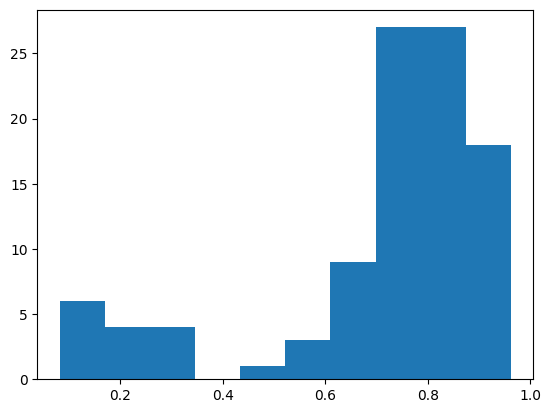

In [101]:

predictions=predict(test.to_numpy()[:,1:]) # here we are removing the label and sending the features for prediction
plt.hist(predictions)
plt.show()

In [102]:
import sklearn

cutoff=0.5  # we can also find the best cutoff using log-loss curve and tune this accordingly
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[14 15]
 [ 0 70]]
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        29
           1       0.82      1.00      0.90        70

    accuracy                           0.85        99
   macro avg       0.91      0.74      0.78        99
weighted avg       0.88      0.85      0.83        99



In [109]:
print("The Accuracy of the XGBoost Model is:", np.round(sklearn.metrics.accuracy_score(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)),2)*100 )

The Accuracy of the XGBoost Model is: 85.0


- Our XGBoost Model is having an accuracy of 85% and we can further tune it to improve.

In [110]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2024-02-04-20-22-31-763
INFO:sagemaker:Deleting endpoint with name: xgboost-2024-02-04-20-22-31-763


In [ ]:
## Making batch predictions

# input data loaction
batch_input = 's3://{}/{}/{}'.format(bucket,sk_prefix,'test_data.csv') # the unseen data

# path to save the batch predictions
batch_output = 's3://{}/{}/batch-predictions'.format(bucket, sk_prefix)

In [ ]:
# creating a transformer object

transformer = xgb_model.transformer(
    instance_count= 1,
    instance_type= 'ml.m4.xlarge',
    output_path=batch_output
)


transformer.transform(
    data = batch_input,
    data_type="S3Prefix",
    content_type='test/csv',
    split_type='Line'
)

transformer.wait()

# The outputs will be stored in the batch_output folder

## As I have said before we can do this entire process by building a train script from scratch and train the estimator on it and deploy.

### Writing training script

In [113]:
%%writefile train.py

import argparse
import os
import json
import numpy as np
import pandas as pd
import sklearn
import s3fs
# import boto3
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split 

# This is created because the scikit learn models once deployed creates a scikit-learn model server which automatically loads the model saved during training
# It invokes the model_fn function to serve the model so we should keep this in our script.

def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, 'model.joblib'))
    return clf



if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    
    # this is for tuning. we can also run jobs for randomsearch or gridsearch to find optimum hyperparameters.
    # parser.add_argument('--epochs', type=int, default=10)
    # parser.add_argument('--batch-size', type=int, default=100)
    parser.add_argument('--n_estimators', type=int, default=10)
    parser.add_argument('--random_state', type = int, default = 0)
    

    # an alternative way to load hyperparameters via SM_HPS environment variable.
    # parser.add_argument('--sm-hps', type=json.loads, default=os.environ['SM_HPS'])
    # SM_HPS='{"batch-size": "256", "learning-rate": "0.0001","epochs": "10"}' one way to load all the hyperparameters through a dict

    # input data and model directories
    parser.add_argument('--output-data-dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    # parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--train-file' , type = str , default ='train_Data.csv')
    # parser.add_argument('--validation-file', type =str , default = 'validation.csv')

    args, _ = parser.parse_known_args()

    print("SM_MODEL_DIR:", os.environ.get('SM_MODEL_DIR'))
    print("SM_CHANNEL_TRAIN:", os.environ.get('SM_CHANNEL_TRAIN'))

    print("sklearn version: " , sklearn.__version__)
    print("joblib version: ", joblib.__version__)


    print("Reading Data")

    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    # train_df = pd.read_csv('s3://loaneligibilitybucket/sagemaker/loaneligibilityalgorithm/sklearncontainer/train_Data.csv')
    # test_df = pd.read_csv(os.path.join(args.validation, args.validation_file))

    y = train_df['Loan_Status']
    X = train_df.drop('Loan_Status', axis = 1)

    # y_val = test_df['Loan_Status']

    print(" Building training and testing datasets")
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state=42)


    print('\nTraining the model')
    model = RandomForestClassifier(n_estimators=args.n_estimators,random_state=args.random_state)
    model.fit(X_train,y_train)

    # inorder to save the model for deployment we should save the model in the training script here
    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, model_path)
    print('\nmodel stored at ',model_path)

    y_pred = model.predict(X_test)

    ##model performance

    test_accuracy = accuracy_score(y_test,y_pred)
    # ClassificationReport = classification_report(y_test, y_pred)
    # confusionmatrix = confusion_matrix(y_test,y_pred)

    print('Model Accuraacy' , test_accuracy)
    # print('\nclassification_Report')
    # print(ClassificationReport)
    # print('\nconfusion Matrix' )
    # print(confusionmatrix)

Overwriting train.py


## Training the model with Estimator

In [117]:
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn


sklearn_estimator = SKLearn(
    entry_point='train.py',
    framework_version='1.0-1',
    role = 'arn:aws:iam::280695184456:role/service-role/AmazonSageMaker-ExecutionRole-20240128T102744',
    instance_count = 1,
    instance_type =  'ml.m4.xlarge', #"ml.t2.micro","ml.t3.medium"
    base_job_name = 'RF-custom-model',
    hyperparameters= {
        "n_estimators" : 15,
        "random_state" : 0
    }
)



# to load a pre-trained model outside aws sagemaker into the sagemaker we use the below format.

# sklearn_model = SKLearnModel(model_data="s3://bucket/model.tar.gz",
#                              role="SageMakerRole",
#                              entry_point="transform_script.py",
#                              framework_version="1.0-1")

# predictor = sklearn_model.deploy(instance_type="ml.c4.xlarge", initial_instance_count=1)


In [118]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, sk_prefix, "train_Data.csv"), content_type="csv"
)

In [120]:
# #launching the training job

sklearn_estimator.fit({"train":train_input})

# # sklearn_estimator.fit({'train':trainpath})

# # this is passing an entire data file and the script can take care of splitting it and running and finally saving the model. We are facing errors due to local environment
# # dependencies for identifying the model train and test paths and model saving directories.

In [ ]:
## Deploying the estimator(model) which gives a predictor object.

In [ ]:
predictor = sklearn_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

response = predictor.predict(test_data[:2].values.to_list())

predictor.delete_endpoint()